In [2]:
!wget -N https://cdn.freecodecamp.org/project-data/sms/train-data.tsv
!wget -N https://cdn.freecodecamp.org/project-data/sms/valid-data.tsv
!pip install tensorflow-datasets

--2022-10-17 04:02:27--  https://cdn.freecodecamp.org/project-data/sms/train-data.tsv
Resolving cdn.freecodecamp.org (cdn.freecodecamp.org)... 104.26.2.33, 104.26.3.33, 172.67.70.149, ...
Connecting to cdn.freecodecamp.org (cdn.freecodecamp.org)|104.26.2.33|:443... connected.
HTTP request sent, awaiting response... 304 Not Modified
File ‘train-data.tsv’ not modified on server. Omitting download.

--2022-10-17 04:02:27--  https://cdn.freecodecamp.org/project-data/sms/valid-data.tsv
Resolving cdn.freecodecamp.org (cdn.freecodecamp.org)... 104.26.2.33, 104.26.3.33, 172.67.70.149, ...
Connecting to cdn.freecodecamp.org (cdn.freecodecamp.org)|104.26.2.33|:443... connected.
HTTP request sent, awaiting response... 304 Not Modified
File ‘valid-data.tsv’ not modified on server. Omitting download.

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [7]:
import tensorflow as tf
import pandas as pd
from tensorflow import keras
# import tensorflow_datasets as tfds
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.layers.experimental.preprocessing import TextVectorization
from tensorflow.keras import layers
from tensorflow.keras.preprocessing import sequence

In [8]:
train_file_path = "train-data.tsv"
test_file_path = "valid-data.tsv"

train_df = pd.read_csv(test_file_path, sep="\t", header=None, names=["type", "msg"])
train_df.dropna()
train_df.head()

,type,msg
0,ham,i am in hospital da. . i will return home in e...
1,ham,"not much, just some textin'. how bout you?"
2,ham,i probably won't eat at all today. i think i'm...
3,ham,don‘t give a flying monkeys wot they think and...
4,ham,who are you seeing?


In [9]:
test_df = pd.read_csv(test_file_path, sep="\t", header=None, names=["type", "msg"])
test_df.dropna()
train_df.head()

,type,msg
0,ham,i am in hospital da. . i will return home in e...
1,ham,"not much, just some textin'. how bout you?"
2,ham,i probably won't eat at all today. i think i'm...
3,ham,don‘t give a flying monkeys wot they think and...
4,ham,who are you seeing?


In [10]:
train_df["type"] = pd.factorize(train_df["type"])[0]
test_df["type"] = pd.factorize(test_df["type"])[0]
train_df.head()

,type,msg
0,0,i am in hospital da. . i will return home in e...
1,0,"not much, just some textin'. how bout you?"
2,0,i probably won't eat at all today. i think i'm...
3,0,don‘t give a flying monkeys wot they think and...
4,0,who are you seeing?


In [11]:
train_labels =  train_df["type"].values
train_ds = tf.data.Dataset.from_tensor_slices(
    (train_df["msg"].values, train_labels)
)

In [12]:
test_labels =  test_df["type"].values
test_ds = tf.data.Dataset.from_tensor_slices(
    (test_df["msg"].values, test_labels)
)
test_ds.element_spec

(TensorSpec(shape=(), dtype=tf.string, name=None),
 TensorSpec(shape=(), dtype=tf.int64, name=None))

In [13]:
BUFFER_SIZE = 100
BATCH_SIZE = 32
train_ds = train_ds.shuffle(BUFFER_SIZE).batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)
test_ds = test_ds.batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)

In [14]:
vec = TextVectorization(
    output_mode='int',
    max_tokens=1000,
    output_sequence_length=1000,
)

vec.adapt(train_ds.map(lambda text, label: text))

In [15]:
vocab = np.array(vec.get_vocabulary())
vocab[:20]

array(['', '[UNK]', 'i', 'to', 'you', 'a', 'the', 'u', 'and', 'is', 'in',
       'me', 'my', 'your', 'for', 'have', 'it', 'of', 'call', 'that'],
      dtype='<U16')

In [16]:
model = tf.keras.Sequential([
    vec,
    tf.keras.layers.Embedding(
        len(vec.get_vocabulary()),
        64,
        mask_zero=True,
    ),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64,  return_sequences=True)),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(32)),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dropout(0.3),
    tf.keras.layers.Dense(1)
])


model.compile(
    loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
    optimizer=tf.keras.optimizers.Adam(1e-4),
    metrics=['accuracy'],
)

In [17]:
history = model.fit(
    train_ds,
    validation_data=test_ds,
    validation_steps=30,
    epochs=10,
)

Epoch 1/10
44/44 [==============================] - 195s 4s/step - loss: 0.6794 - accuracy: 0.8657 - val_loss: 0.6575 - val_accuracy: 0.8604
Epoch 2/10
44/44 [==============================] - 150s 3s/step - loss: 0.6138 - accuracy: 0.8657 - val_loss: 0.5547 - val_accuracy: 0.8604
Epoch 3/10
44/44 [==============================] - 148s 3s/step - loss: 0.5113 - accuracy: 0.8657 - val_loss: 0.4777 - val_accuracy: 0.8604
Epoch 4/10
44/44 [==============================] - 148s 3s/step - loss: 0.4413 - accuracy: 0.8657 - val_loss: 0.4028 - val_accuracy: 0.8604
Epoch 5/10
44/44 [==============================] - 147s 3s/step - loss: 0.3561 - accuracy: 0.8657 - val_loss: 0.2950 - val_accuracy: 0.8604
Epoch 6/10
44/44 [==============================] - 147s 3s/step - loss: 0.2336 - accuracy: 0.8657 - val_loss: 0.1728 - val_accuracy: 0.8604
Epoch 7/10
44/44 [==============================] - 147s 3s/step - loss: 0.1500 - accuracy: 0.8915 - val_loss: 0.1268 - val_accuracy: 0.9750
Epoch 8/10
44

In [18]:
test_loss, test_acc = model.evaluate(test_ds)

44/44 [==============================] - 30s 693ms/step - loss: 0.0452 - accuracy: 0.9892


In [19]:
print('Test Loss:', test_loss)
print('Test Accuracy:', test_acc)

Test Loss: 0.045154817402362823
Test Accuracy: 0.9892241358757019


In [20]:
def plot_graphs(h, metric):
    plt.plot(h.history[metric])
    plt.plot(h.history['val_'+metric])
    plt.xlabel("Epochs")
    plt.ylabel(metric)
    plt.legend([metric, 'val_'+metric])

(0.0, 0.7110424814745784)

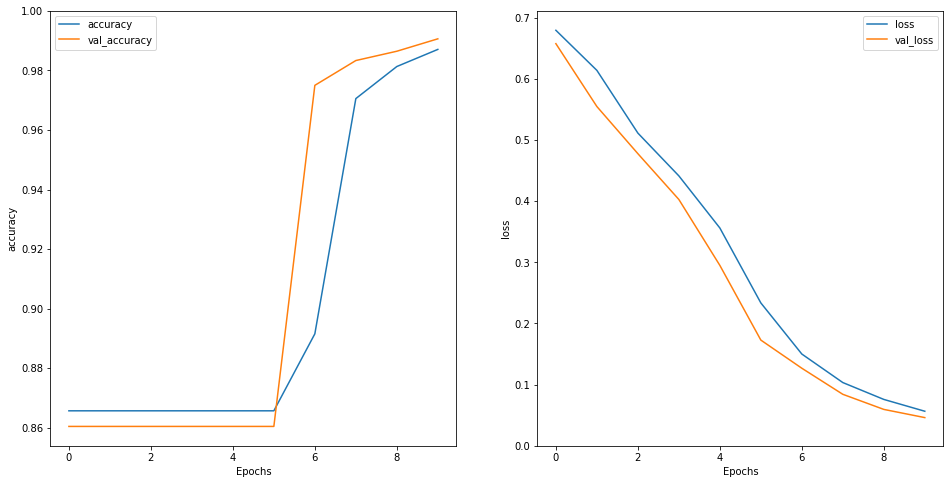

In [21]:
plt.figure(figsize=(16, 8))
plt.subplot(1, 2, 1)
plot_graphs(history, 'accuracy')
plt.ylim(None, 1)
plt.subplot(1, 2, 2)
plot_graphs(history, 'loss')
plt.ylim(0, None)

In [22]:
h = history.history
print(h['loss'])
print(h['val_loss'])
print(h['accuracy'])
print(h['val_accuracy'])

[0.6793792247772217, 0.6138448119163513, 0.5113246440887451, 0.44134223461151123, 0.3561463952064514, 0.23361927270889282, 0.15003561973571777, 0.10339641571044922, 0.0758248046040535, 0.05650929734110832]
[0.6575158834457397, 0.5547278523445129, 0.4776631295681, 0.4027683138847351, 0.2950044870376587, 0.172848179936409, 0.1268155723810196, 0.08419286459684372, 0.05950847640633583, 0.04611409083008766]
[0.8656609058380127, 0.8656609058380127, 0.8656609058380127, 0.8656609058380127, 0.8656609058380127, 0.8656609058380127, 0.891523003578186, 0.9705459475517273, 0.9813218116760254, 0.9870689511299133]
[0.8604166507720947, 0.8604166507720947, 0.8604166507720947, 0.8604166507720947, 0.8604166507720947, 0.8604166507720947, 0.9750000238418579, 0.9833333492279053, 0.9864583611488342, 0.9906250238418579]


In [23]:
# function to predict messages based on model
# (should return list containing prediction and label, ex. [0.008318834938108921, 'ham'])
def predict_message(pred_text):
    ps = model.predict([pred_text])
    print(ps)
    p = ps[0][0]
    return [p, "ham" if p <0.5 else "spam"]

pred_text = "how are you doing today?"

prediction = predict_message(pred_text)
print(prediction)

1/1 [==============================] - 7s 7s/step
[[-4.008453]]
[-4.008453, 'ham']


In [24]:
# Run this cell to test your function and model. Do not modify contents.
def test_predictions():
  test_messages = ["how are you doing today",
                   "sale today! to stop texts call 98912460 4",
                   "i dont want to go. can we try it a different day? available sat",
                   "our new mobile video service is live. just install on your phone to start watching.",
                   "you have won £1000 cash! call to claim your prize.",
                   "i'll bring it tomorrow. don't forget the milk.",
                   "wow, is your arm alright. that happened to me one time too"
                  ]

  test_answers = ["ham", "spam", "ham", "spam", "spam", "ham", "ham"]
  passed = True

  for msg, ans in zip(test_messages, test_answers):
    prediction = predict_message(msg)
    if prediction[1] != ans:
      passed = False

  if passed:
    print("You passed the challenge. Great job!")
  else:
    print("You haven't passed yet. Keep trying.")

test_predictions()

1/1 [==============================] - 0s 279ms/step
[[-4.008453]]
1/1 [==============================] - 0s 278ms/step
[[0.59120363]]
1/1 [==============================] - 0s 281ms/step
[[-10.165424]]
1/1 [==============================] - 0s 283ms/step
[[1.03136]]
1/1 [==============================] - 1s 528ms/step
[[2.0401053]]
1/1 [==============================] - 1s 589ms/step
[[-8.280863]]
1/1 [==============================] - 1s 554ms/step
[[-9.219103]]
You passed the challenge. Great job!
